# TRABALHO FINAL PAA
# Resolução do Problema MAX-3SAT com Metaheurística Genetic Algorithm

## Professor: Dr. Leonardo S. Rocha
## Equipe:
### Davi Montesuma
### Kaio Rodrigues
### Vinicius Sampaio

Codigo feito em python 3.9 

Requer as bibliotecas Numpy, Bokeh e Tqdm

## Importação das bibliotecas

In [1]:
import numpy as np # para criação e manipulação de vetores
import time
from tqdm.notebook import trange, tqdm # Cria barras de visualização de progresso
from bokeh.plotting import figure, show, ColumnDataSource # O Bokeh é responsável pela plotagem do grafico
from bokeh.io import output_notebook, push_notebook, show
from bokeh.models import Paragraph
from bokeh.layouts import row, column
output_notebook() # Seta o output do Bokeh no output da célula do notebook

Loading BokehJS ...

## Leitura dos dados e parâmetros 

In [2]:

textfile = 'SAT1.txt' # Nome do arquivo de texto a ser lido


param = np.loadtxt(textfile,max_rows=1,dtype=int) # lê a primeira linha do arquivo para salvar o numero de variáveis e cláusulas
constr = np.loadtxt(textfile,skiprows=1,dtype=int) # Lê o resto do arquivo com as cláusulas

### Parâmetros

In [3]:
population_size = 1000 # tamanho da população
generations = 100 # Numero maximo de gerações a serem computadas
mutation_rate = 0.05 # Taxa de mutação
N = 10 # Quantidade dos melhores resultados a serem considerados como "pais" pricipais
K = 100 # Quantidade dos melhores resultados a serem considerados como "pais" secundarios
MAX_REP = 20 # Quantidade maxima de vezes que um resultado pode ser obtido em sequencia

n_var = param[0] # numero de variaveis (coletado do arquivo)
n_constr = param[1] # numero de cláusulas (coletado do arquivo)

## Funções

In [4]:
# Função que calcula o valor.
# Para um membro da população ela cria todas as cláusulas e testa se a soma de cada uma
# é maior ou igual a 1, se sim, significa que a cláusula é verdadeira e é adicionado 1 ao score
def score(x):
    score = 0
    for i in constr:
        x1,x2,x3 = x[abs(i[0])-1],x[abs(i[1])-1],x[abs(i[2])-1]
        if i[0] < 0:
            x1 = 1 - x1
        if i[1] < 0:
            x2 = 1 - x2
        if i[2] < 0:
            x3 = 1 - x3
        if x1 + x2 + x3 >= 1:
            score += 1
    return score


In [5]:
# Função que encontra o melhor membro da população.
# Ela usa a função score() para calcular o valor de cada membro e retorna o indice do que tem o valor melhor.
def find_best(population):
    scores = []
    for i in population:
        scores.append(score(i))
    return np.argmax(scores)

In [6]:
# Função que retorna o indice dos N melhores membros da população
def topN(population, n):
    scores = []
    for i in population:
        scores.append(score(i))
    return sorted(range(len(scores)), key = lambda sub: scores[sub])[-n:]

In [7]:
# Função que cria um Subset da população
# ela é utilizada para criar os grupos dos melhores membros que irão participar do crossover
def select_top(population, top):
    x = []
    for i in top:
        x.append(population[i])
    return x

In [8]:
# Faz o crossover entre dois membros da população
# Utiliza a tecnica de "Uniform crossover" onde cada cromossomo tem chance igual de ser escolhido
# do progenitor 1 ou 2
def crossover(parent1,parent2):
    child = np.zeros(n_var)
    for i in range(n_var):
        if np.random.rand() < 0.5:
            child[i] = parent1[i]
        else:
            child[i] = parent2[i]
    return child

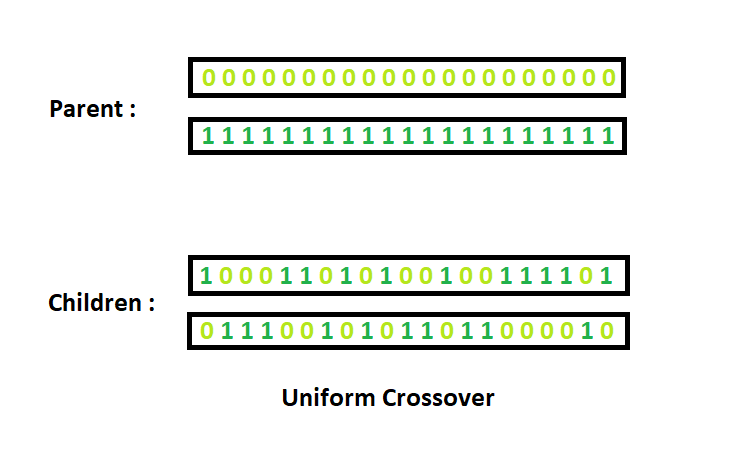

In [9]:
# Introduz mutação a um membro da população
# A change de existir mutação em um cromossomo é determinada pela taxa de mutação
# Se houver mutação o valor do cromossomo é trocado
def mutate(child):
    for i in range(n_var):
        if np.random.rand() < mutation_rate:
            child[i] = 1 - child[i]
    return child

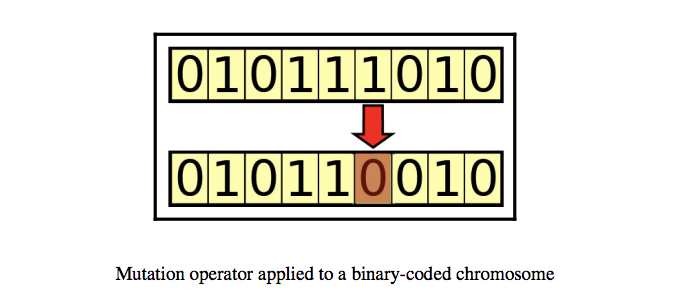

In [10]:
# Realiza a reprodução da população
# É realizado o crossover entre os N melhores membros e os K melhores membros
# O tamanho da população não é alterado
def reproduce(population):
    children = []
    #parent1 = population[find_best(population)]
    top = select_top(population,topN(population,N))
    rest = select_top(population,topN(population,K))
    for i in range(population_size):
        parent1 =  top[np.random.randint(len(top))]
        parent2 =  rest[np.random.randint(len(rest))] #population[np.random.randint(population_size)] #population[i]
        child = crossover(parent1,parent2)
        child = mutate(child)
        children.append(child)
    return children

In [11]:
# Chama a função de reprodução
def next_generation(population):
    children = reproduce(population)
    return children

## Execução

### Criação da população inicial

Usando os parâmetros fornecidos e coletados nos arquivos uma população inicial é criada.

Uma matriz Tamanho da População por Numero de Variaveis é criada.

Cada menbro da população é uma linha da matrix e cada posição dessa linha representa uma variavel.

O valor das variaveis é atribuido de forma aleatoria com valores inteiros entre 0 e 1.

In [12]:
population = np.random.randint(2,size=(population_size,n_var))

### Inicialização do ambiente para visualização da execução

In [13]:
# Utilizamos Bokeh para fazer a visualização
# salvamos sempre os melhores valores de cada geração para plotagem e para determinar a melhor solução
results = [] # vetor para salvar o valor do melhor resultado
best = find_best(population)
results.append(score(population[best]))
winners = [] # vetor para salvar o melhor resultado
winners.append(population[best])
epochs = [] # vetor para salvar o numero da geração (utilizado para criar o eixo x do plot)
epochs.append(0)
data = {'x_values': epochs,
        'y_values': results} # dicionario com os dados a ser utilizado pelo Bokeh
source = ColumnDataSource(data) # estrutura do Bokeh para guardar/atualizar os dados
p = figure(title="Solution Value for "+textfile, x_axis_label='Generation', y_axis_label='S') # inicialização da figura
p.line(x='x_values', y='y_values', source=source, line_width=2) # criação do line plot dos valores das soluções

q = Paragraph(text='Generation: '+str(epochs[-1])+'Solution Value: '+str(results[-1]), 
                width=210, height=100) # texto que mostra info da geração atual
q1 = Paragraph(text='Best Value: '+str(np.max(results))+' at Generation '+str(epochs[np.argmax(results)]),
               width=210, height=100) # texto que mostra info da melhor geração
q2= Paragraph(text=str(winners[epochs[np.argmax(results)]]),
               width=210, height=100) # texto que mostra  o melhor membro da melhor geração

### Execução

In [ ]:
start_time = time.time()
target = show(row(p, column(q,q1,q2)), notebook_handle=True) # handle do Bokeh para visualizar e atualizar os dados
old_value = 0 # variavel utilizada para determinar se houve repetição de valores
new_value = 0 # variavel utilizada para determinar se houve repetição de valores
count = 0 # variavel utilizada para determinar quantas repetições aconteceram

for i in trange(generations):
    population = next_generation(population) # Gera a nova população
    best = find_best(population) # Encontra o melhor membro da população
    results.append(score(population[best])) # salva o valor da melhor solução da população atual
    winners.append(population[best]) # salva a melhor solução da população atual
    epochs.append(i+1) # salva a geração atual
    q.text = 'Generation: '+str(epochs[-1])+ ' Solution Value: '+str(results[-1]) # atualiza o texto
    q1.text = 'Best Value: '+str(np.max(results))+' at Generation '+str(epochs[np.argmax(results)]) # atualiza o texto
    q2.text = str(winners[epochs[np.argmax(results)]]) # atualiza o texto
    source.data.update({"y_values": results,
                        "x_values": epochs}) # atualiza os dados do plot
    push_notebook(handle=target) # redesenha o plot
    new_value = results[-1] 
    if new_value == old_value:
        count += 1
        if count == MAX_REP:
            print('Reached maximum repetition of value') # se o melhor valor atual for obtido MAX_REP vezes para a execução
            break
    else:
        count = 0
    old_value = new_value # reseta o contador caso haja mudança no melhor valor atual

ttime = time.time() - start_time
print('Time: ', ttime)

  0%|          | 0/100 [00:00<?, ?it/s]

Output for "luck time" with SAT3.txt

Generation: 300 Solution Value: 1491

Best Value: 1497 at Generation 227

[1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0.]

Output for SAT2.txt

Generation: 100 Solution Value: 494

Best Value: 494 at Generation 59

[1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]

Output for SAT1.txt

Generation: 28 Solution Value: 272

Best Value: 272 at Generation 8

[1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]